# Resumen y contexto (Abstract)

Una alarma de incendios es un dispositivo capaz de detectar la presencia de fuego y, en consecuencia, emitir una señal que alerte a las personas de un posible incendio. Para ello, consta de un detector que supervisa los cambios ambientales asociados con la [combustión](https://es.wikipedia.org/wiki/Combusti%C3%B3n).
Los detectores de humo más comunes suelen ser: **detectores iónicos** que tienen una corriente eléctrica constante en su sistema que disminuye en presencia de humo, y **detectores ópticos** que detectan humo por oscurecimiento o dispersión del aire.

El [autor](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset) del dataset seleccionado logró crear un detector de humo con la ayuda de dispositivos [IoT](https://es.wikipedia.org/wiki/Internet_de_las_cosas) y un modelo de IA. Para ello, se realizaron numerosas pruebas en distintas condiciones externas y con diferentes fuentes de fuego, de esa manera se garantiza una muestra heterogénea de datos para el entrenamiento de la IA. 

Las variables del dataset son:
- UTC: Tiempo Universal coordinado (tiempo en el que se llevó a cabo el experimento). 
- Temperature[C]: Temperatura de los alrededores, en Celsius.
- Humidity[%]: Humedad de ambiente.
- TVOC[ppb]: Compuestos organicos volatiles totales, en ppb. 
- eCO2[ppm]: Concentración de CO<sub>2</sub>, en ppm.
- Raw H2: Hidrógeno crudo en alrededores.
- Raw Ethanol: Etanol crudo en el ambiente.
- Pressure[hPa]: Presión atmosférica, en hPa.
- PM1.0: Partículas de diámetro menor a 1.0 micrómetros.
- PM2.5: Partículas de diámetro menor a 2.5 micrómetros.
- NC0.5: Concentración de particulas de diámetro menor a 0.5 micrómetros.
- NC1.0: Concentración de particulas de diámetro menor a 1.0 micrómetros.
- NC2.5: Concentración de particulas de diámetro menor a 2.5 micrómetros.
- CNT: Contador de prueba.
- Fire Alarm: 1 positivo,  0 no positivo. 

Para recolección de datos de entrenamiento se muestrearon muchos entornos y distintas fuentes de fuego que incluyen:

- Interiores normales
- Normal al aire libre
- Fuego de leña interior, zona de formación de bomberos
- Chimenea de gas interior, área de entrenamiento de bomberos
- Parrilla exterior de leña, carbón y gas
- Alta humedad exterior

El conjunto de datos tiene casi 60.000 lecturas. Se ha testeado en condiciones extremas de temperatura para verificar el correcto funcionamiento del sensor y evitar falsas alarmas.

[Fuente](https://www.hackster.io/stefanblattmann/real-time-smoke-detection-with-ai-based-sensor-fusion-1086e6).

# Problema a resolver
Se busca determinar si existe una relación entre las condiciones ambientales y la activación de la alarma de incendios en un edificio. 
Se busca utilizar ML para incorporar el modelo a sensores, de manera que permita reducir las falsas alarmas y detectar errores o fallas del sensor. Para ello, se utilizará el 80% del dataset para entrenar el modelo, y finalmente se testeará el mismo usando el 20% del dataset restante. 
Esto permitiría incorporar el modelo a los sensores de cualquier tipo de negocio u hogar, utilizándose como una medida extra de seguridad.

# Hipótesis

Con la presente información se plantean las siguientes hipótesis.

1. La mayor densidad de muestras debe estar en un rango de temperatura ambiente 15-30 ºC. Esto es porque se esperaría que el detector de humo esté mejor testeado en temperaturas de funcionamiento normales. 
2. La concentración de CO<sub>2</sub> y la temperatura aumentan significativamente en presencia de un incendio.
3. La concentración de partículas PM1.0 y PM2.5, así como la concentración de compuestos orgánicos volátiles totales (TVOC), puede ser útil para determinar la presencia de un incendio.
4. La humedad relativa y la presión atmosférica pueden tener un efecto en la propagación del fuego y la generación de humo. El fuego puede disminuir la humedad relativa del aire en un área determinada.
5. El nivel de partículas PM1.0 y PM2.5 en el aire también pueden estar relacionados con la activación de la alarma de incendios. Se espera que un aumento en el nivel de partículas en el aire aumente la probabilidad de que suene la alarma de incendios. 

# Análisis exploratorio de datos (Exploratory Data Analysis)

Se aplicará análisis exploratorio de datos, de ahora en mas EDA, para hacer una exploración inicial de los datos, identificar patrones y chequear las hipótesis planteadas. 

In [54]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
df_smoke=pd.read_csv('/workspaces/codespaces-blank/Proyecto_DS/datasets/raw/smoke_detection_iot.csv')

df_smoke = df_smoke.drop('Unnamed: 0', axis='columns')
df_smoke.index = df_smoke['CNT']
df_smoke = df_smoke.drop('CNT', axis='columns')

from datetime import datetime

df_smoke['UTC'] = pd.to_datetime(df_smoke['UTC'], unit='s')
df_smoke.head()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
CNT,,,,,,,,,,,,,,
0,2022-06-09 00:08:51,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,2022-06-09 00:08:52,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0
2,2022-06-09 00:08:53,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0
3,2022-06-09 00:08:54,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0
4,2022-06-09 00:08:55,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0


In [56]:
df_smoke.shape

(62630, 14)

## Visualizaciones y análisis de correlación con variable Temperatura

In [57]:
df_smoke['Temperature[C]'] = df_smoke['Temperature[C]'].astype(int)
grouped = df_smoke.groupby('Temperature[C]').agg({'Fire Alarm': ['count', 'sum']})
grouped.columns = ['Numero experimentos', 'Alarma sonó']
grouped['Alarma no sonó'] = grouped['Numero experimentos'] - grouped['Alarma sonó']
grouped = grouped.reset_index()

print(grouped)

    Temperature[C]  Numero experimentos  Alarma sonó  Alarma no sonó
0              -22                   86           69              17
1              -21                  744          606             138
2              -20                  345          280              65
3              -19                  266          217              49
4              -18                  226          183              43
..             ...                  ...          ...             ...
77              55                   92            0              92
78              56                   87            0              87
79              57                   99            0              99
80              58                   46            0              46
81              59                   64            0              64

[82 rows x 4 columns]


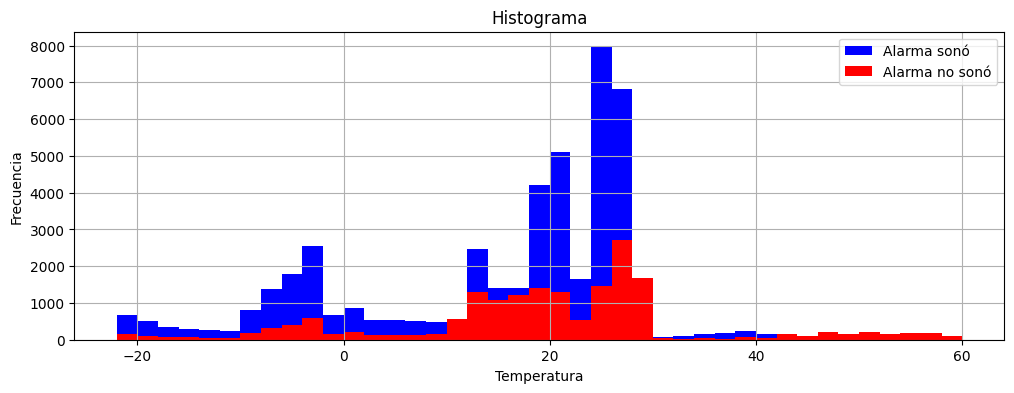

In [58]:
x = df_smoke['Temperature[C]'].dropna()
y = df_smoke['Fire Alarm'].dropna()

#como tengo un millón de valores de x no tiene sentido que considere todos distintos cuando la variación 
# entre temperaturas es tan pequeña (aparte que no me deja matplotlib), por lo tanto agrupo las x 
# definiendo los intervalos de los bins (xmin y xmax), con las y asociadas correspondientes. 
bin_edges = np.arange(x.min(), np.ceil(x.max()) + 2, 2)

# Selecciona los valores de x correspondientes a cada intervalo
x_binned = np.digitize(x, bin_edges) - 1

hist, _ = np.histogram(x, bins=bin_edges)


fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.hist(x[y == 1], bins=bin_edges, color='blue', label='Alarma sonó')
ax1.hist(x[y == 0], bins=bin_edges, color='red', label='Alarma no sonó')

ax1.set_title('Histograma')
ax1.set_ylabel('Frecuencia')
ax1.set_xlabel('Temperatura')
ax1.grid(True)

ax1.legend()

plt.show()

ax1.legend()

plt.show()

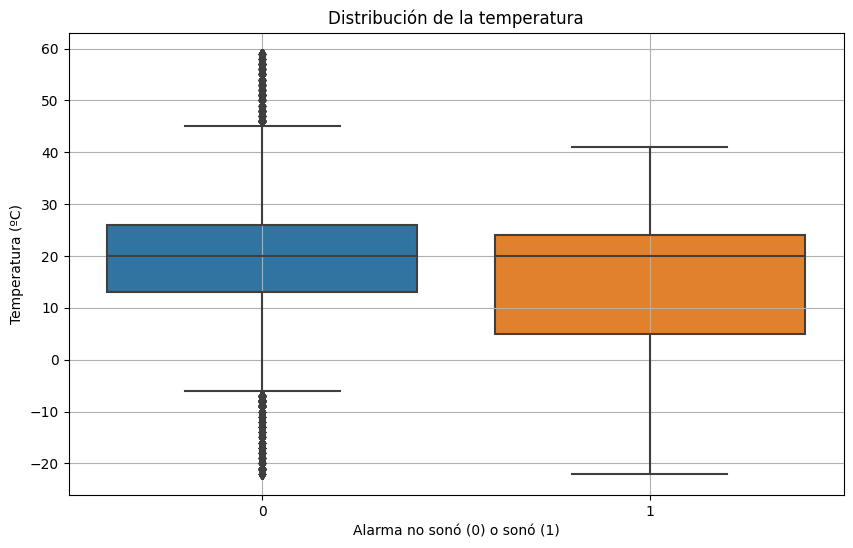

In [59]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='Temperature[C]', data=df_smoke, ax=ax1)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('Temperatura (ºC)')
ax1.set_title('Distribución de la temperatura')
ax1.grid(True)


plt.show()

Se observa que la mayor cantidad de experimentos fueron hechos en temperaturas entre 10-30ºC. Los datos donde la alarma no sonó correspondientes al rango de temperaturas (-20:-5ºC)ºC y (45:60ºC) se consideran outliers.
La alarma sonó mayormente en el rango de temperaturas de 18-30ºC.
La alarma no sonó mayormente en el rango de temperaturas de 18-30ºC.

In [60]:
x = df_smoke['Temperature[C]'].dropna()
y = df_smoke['Fire Alarm'].dropna()

corr = x.corr(y)

print('Coeficiente de correlación temperatura:', corr)

Coeficiente de correlación temperatura: -0.1651974411164065


Como el coeficiente de correlación es cercano al valor 0, diríamos que no existe una correlación entre la temperatura y la activación de alarma, o la misma es muy baja.

## Visualizaciones y análisis de correlación con variable Humedad

In [61]:
df_smoke['Humidity[%]'] = df_smoke['Humidity[%]'].astype(int)
grouped_hum = df_smoke.groupby('Humidity[%]').agg({'Fire Alarm': ['count', 'sum']})
grouped_hum.columns = ['Numero experimentos', 'Alarma sonó']
grouped_hum['Alarma no sonó'] = grouped_hum['Numero experimentos'] - grouped_hum['Alarma sonó']
grouped_hum = grouped_hum.reset_index()

print(grouped_hum)

    Humidity[%]  Numero experimentos  Alarma sonó  Alarma no sonó
0            10                   32            0              32
1            11                  274            0             274
2            12                  306            0             306
3            13                  351          113             238
4            14                  325          137             188
..          ...                  ...          ...             ...
61           71                    8            0               8
62           72                    8            0               8
63           73                   14            0              14
64           74                   12            0              12
65           75                    4            0               4

[66 rows x 4 columns]


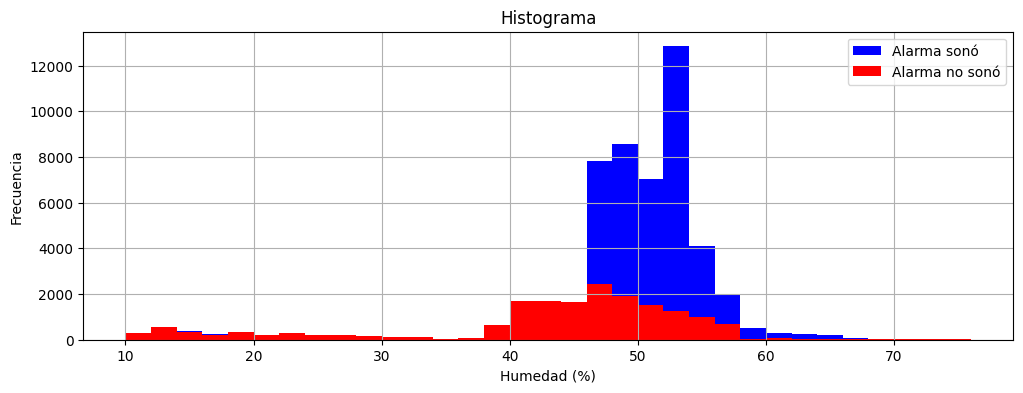

In [62]:
x_h = df_smoke['Humidity[%]'].dropna()
y_h = df_smoke['Fire Alarm'].dropna()

bin_edges = np.arange(x_h.min(), np.ceil(x_h.max()) + 2, 2)

# Selecciona los valores de x correspondientes a cada intervalo
x_binned = np.digitize(x_h, bin_edges) - 1

hist, _ = np.histogram(x_h, bins=bin_edges)


fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.hist(x_h[y_h == 1], bins=bin_edges, color='blue', label='Alarma sonó')
ax1.hist(x_h[y_h == 0], bins=bin_edges, color='red', label='Alarma no sonó')

ax1.set_title('Histograma')
ax1.set_ylabel('Frecuencia')
ax1.set_xlabel('Humedad (%)')
ax1.grid(True)

# Agregar la leyenda
ax1.legend()

plt.show()

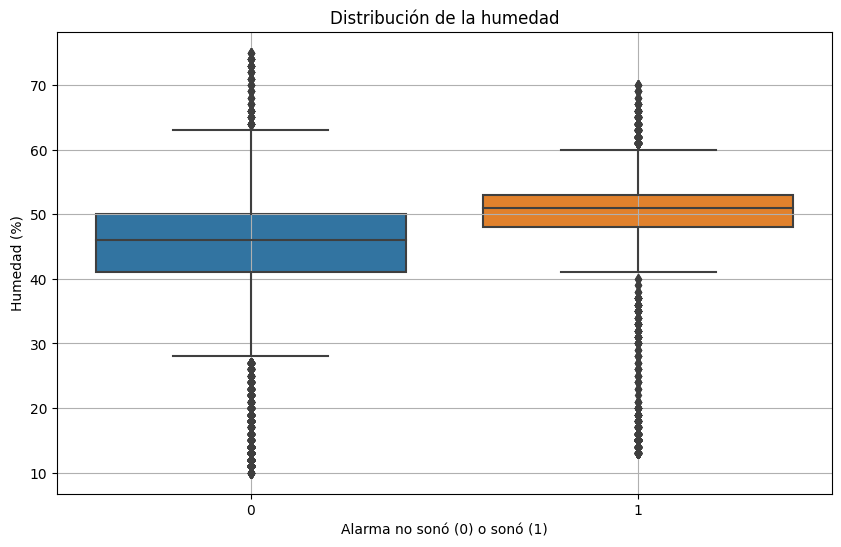

In [63]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='Humidity[%]', data=df_smoke, ax=ax1)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('Humedad (%)')
ax1.set_title('Distribución de la humedad')
ax1.grid(True)


plt.show()

Se observa que la mayor cantidad de experimentos fueron hechos a humedad entre 46-58%. Los datos donde la alarma sonó mayormente se encuentran en el rango de humedad del 48-58%.
La alarma no sonó mayormente en el rango de humedad del 40-58%.

In [64]:
x_h = df_smoke['Humidity[%]'].dropna()
y_h = df_smoke['Fire Alarm'].dropna()

corr = x_h.corr(y_h)

print('Coeficiente de correlación humedad:', corr)

Coeficiente de correlación humedad: 0.399508938153751


El coeficiente de correlación de la humedad es 0.4, bastante mas bajo que 1. No se podría decir que existe una correlación clara entre la humedad y el evento alarma.

### A partir de las variables siguientes no se realizan mas las visualizaciones utilizando histogramas, ya que tarda muchísimo en ejecutar el gráfico. 

## Visualizaciones y análisis de correlación con variable TVOC

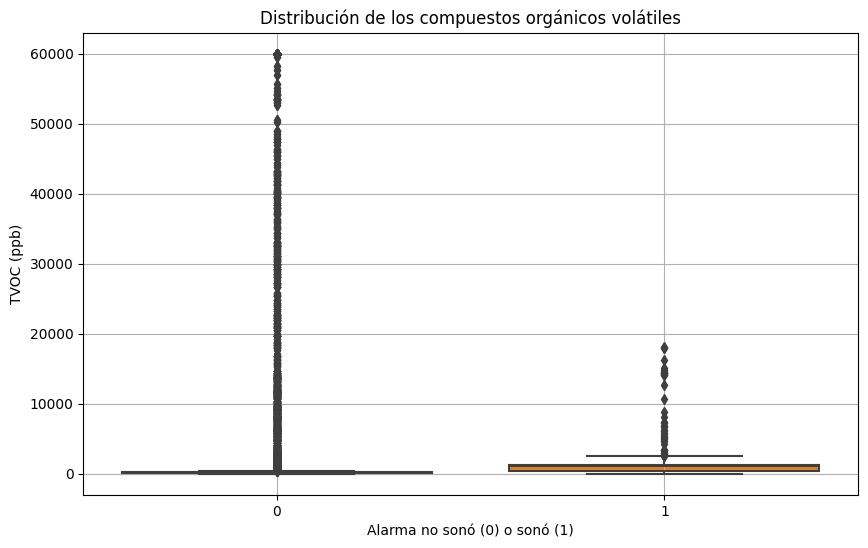

In [65]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='TVOC[ppb]', data=df_smoke, ax=ax1)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('TVOC (ppb)')
ax1.set_title('Distribución de los compuestos orgánicos volátiles')
ax1.grid(True)


plt.show()

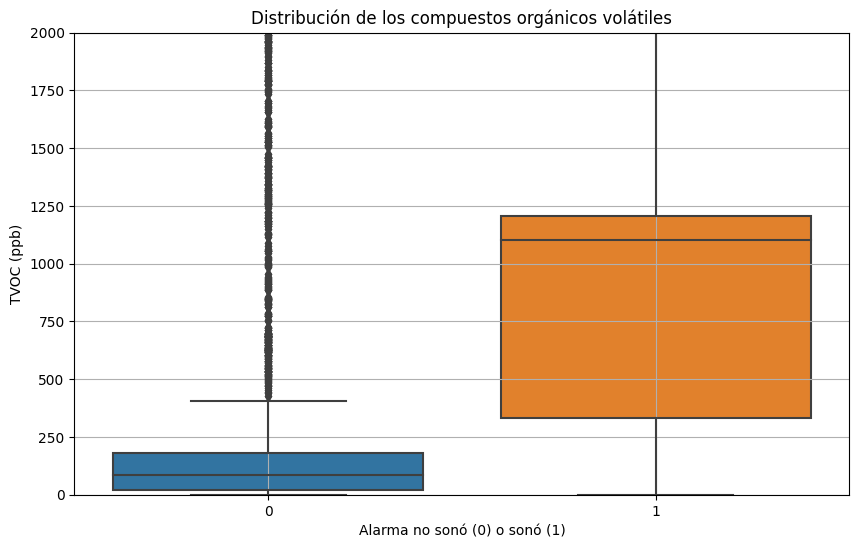

In [66]:
#hacemos zoom, no se entiende nada si no.
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='TVOC[ppb]', data=df_smoke, ax=ax1)
plt.ylim(0, 62000)
plt.ylim(0, 2000, 100)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('TVOC (ppb)')
ax1.set_title('Distribución de los compuestos orgánicos volátiles')
ax1.grid(True)


plt.show()

Se observa que hay una gran cantidad de datos que se encuentran fuera de la caja. Los datos donde la alarma sonó mayormente en el rango de TVOC de 300-1200ppb.
La alarma no sonó mayormente en el rango de TVOC del 40-200ppb.

In [67]:
x_tvoc = df_smoke['TVOC[ppb]'].dropna()
y_tvoc = df_smoke['Fire Alarm'].dropna()

corr = x_tvoc.corr(y_tvoc)

print('Coeficiente de correlación TVOC', corr)

Coeficiente de correlación TVOC -0.21474344468025708


El coeficiente de correlación de TVOC es -0.215, por lo tanto no existe correlación entre TVOC y alarma.

## Visualizaciones y análisis de correlación con variable CO2

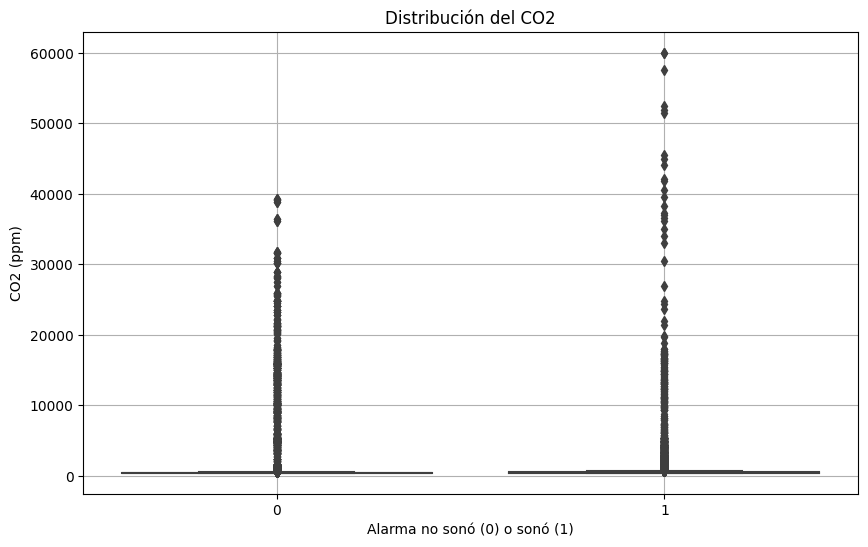

In [68]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='eCO2[ppm]', data=df_smoke, ax=ax1)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('CO2 (ppm)')
ax1.set_title('Distribución del CO2')
ax1.grid(True)


plt.show()

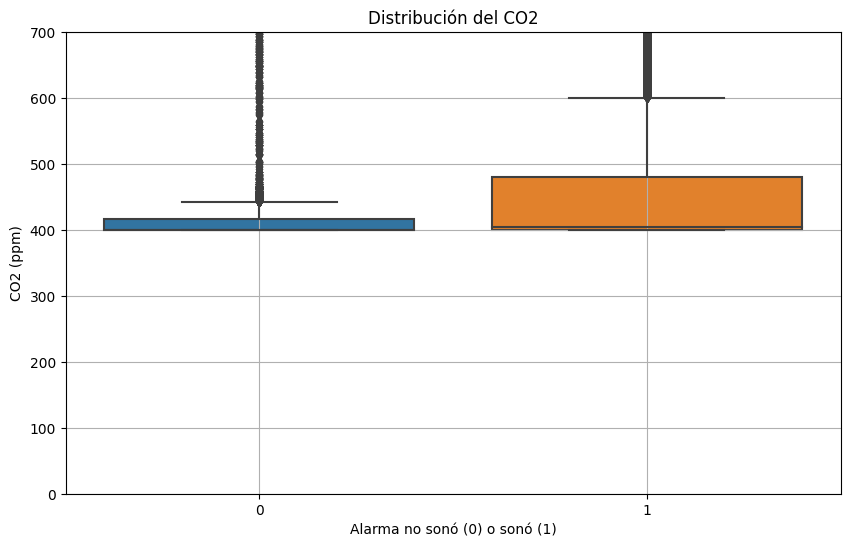

In [69]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='eCO2[ppm]', data=df_smoke, ax=ax1)
plt.ylim(0, 62000)
plt.ylim(0, 700, 100)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('CO2 (ppm)')
ax1.set_title('Distribución del CO2')
ax1.grid(True)


plt.show()

Los datos donde la alarma sonó mayormente se encuentran en el rango de CO2 del 400-480 ppm.
La alarma no sonó mayormente en el rango de CO2 del 400-420 ppm.

In [70]:
x_co2 = df_smoke['eCO2[ppm]'].dropna()
y_co2 = df_smoke['Fire Alarm'].dropna()

corr = x_co2.corr(y_co2)

print('Coeficiente de correlación CO2:', corr)

Coeficiente de correlación CO2: -0.09700610890253594


Muy baja correlación entre CO2 y el disparo de alarma

## Visualizaciones y análisis de correlación con variable Etanol crudo

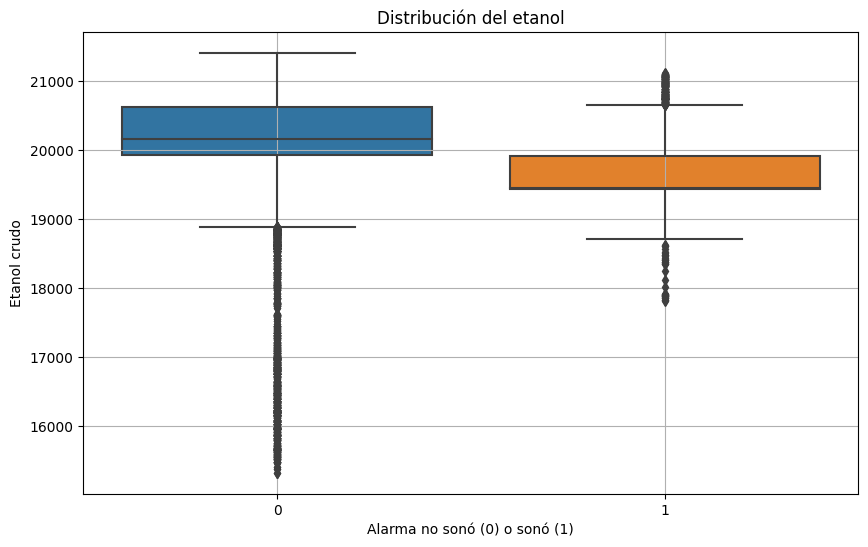

In [71]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='Raw Ethanol', data=df_smoke, ax=ax1)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('Etanol crudo')
ax1.set_title('Distribución del etanol')
ax1.grid(True)


plt.show()

La mayor concentración de etanol que causa que la alarma suene se encuentra en el rango de 19400-19950 ppm
La mayor concentración de etanol que causa que la alarma no suene se encuentre en el rango de 19950-20500ppm

In [72]:
x_h = df_smoke['Raw Ethanol'].dropna()
y_h = df_smoke['Fire Alarm'].dropna()

corr = x_h.corr(y_h)

print('Coeficiente de correlación etanol crudo:', corr)

Coeficiente de correlación etanol crudo: -0.34065184544555827


No hay correlación signficativa con el etanol crudo

## Visualizaciones y análisis de correlación con variable H2 crudo

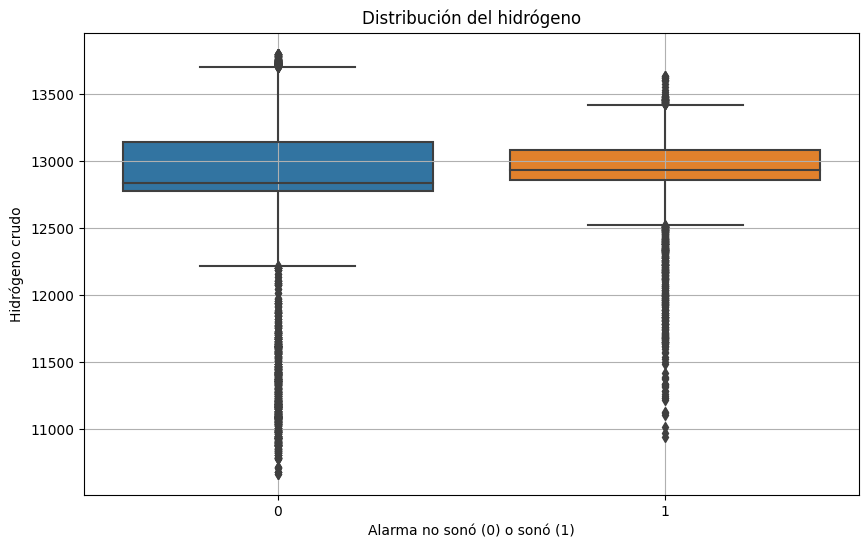

In [73]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='Raw H2', data=df_smoke, ax=ax1)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('Hidrógeno crudo')
ax1.set_title('Distribución del hidrógeno')
ax1.grid(True)


plt.show()

In [74]:
x_h = df_smoke['Raw H2'].dropna()
y_h = df_smoke['Fire Alarm'].dropna()

corr = x_h.corr(y_h)

print('Coeficiente de correlación hidrógeno:', corr)

Coeficiente de correlación hidrógeno: 0.10700702423539715


## Visualizaciones y análisis de correlación con variable presión atmosférica

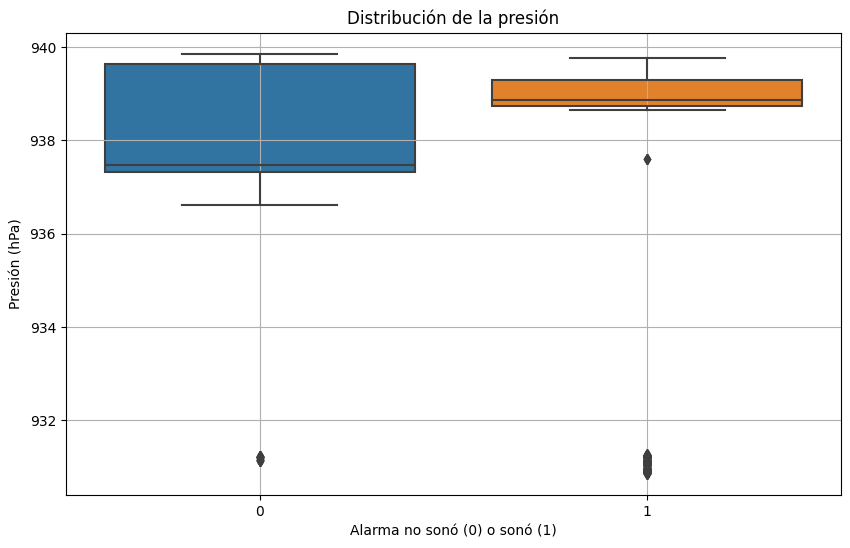

In [75]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='Pressure[hPa]', data=df_smoke, ax=ax1)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('Presión (hPa)')
ax1.set_title('Distribución de la presión')
ax1.grid(True)


plt.show()

In [76]:
x_h = df_smoke['Pressure[hPa]'].dropna()
y_h = df_smoke['Fire Alarm'].dropna()

corr = x_h.corr(y_h)

print('Coeficiente de correlación de la presión:', corr)

Coeficiente de correlación de la presión: 0.24979692788080604


## Visualizaciones y análisis de correlación con variable PM2.5

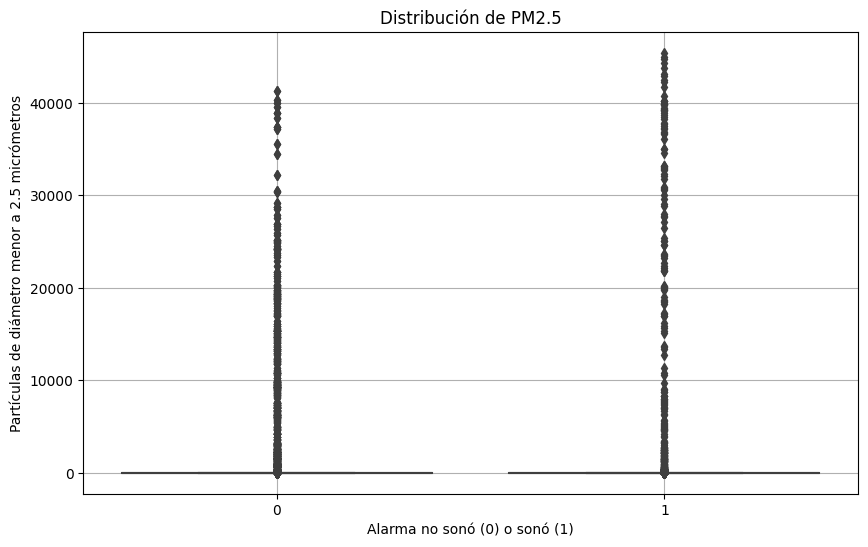

In [77]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='PM2.5', data=df_smoke, ax=ax1)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('Partículas de diámetro menor a 2.5 micrómetros')
ax1.set_title('Distribución de PM2.5')
ax1.grid(True)


plt.show()

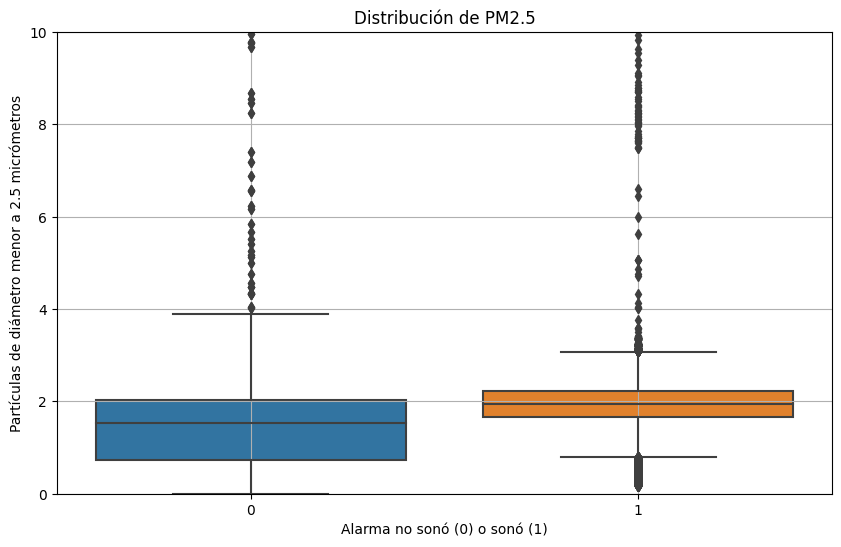

In [78]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='PM2.5', data=df_smoke, ax=ax1)
plt.ylim(0, 50000)
plt.ylim(0, 10, 1)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('Partículas de diámetro menor a 2.5 micrómetros')
ax1.set_title('Distribución de PM2.5')
ax1.grid(True)


plt.show()

In [79]:
x_h = df_smoke['PM2.5'].dropna()
y_h = df_smoke['Fire Alarm'].dropna()

corr = x_h.corr(y_h)

print('Coeficiente de correlación de PM2.5:', corr)

Coeficiente de correlación de PM2.5: -0.08491638525060596


## Visualizaciones y análisis de correlación con variable NC2.5

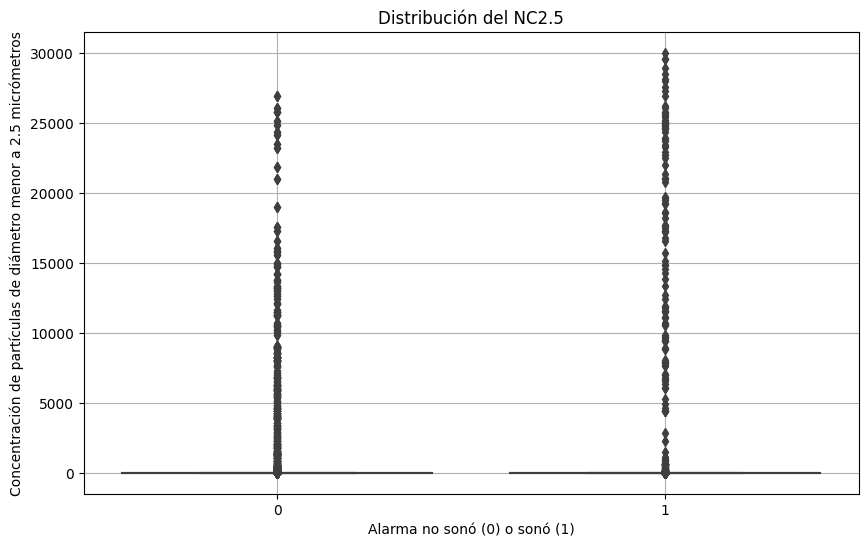

In [80]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='NC2.5', data=df_smoke, ax=ax1)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('Concentración de partículas de diámetro menor a 2.5 micrómetros')
ax1.set_title('Distribución del NC2.5')
ax1.grid(True)


plt.show()

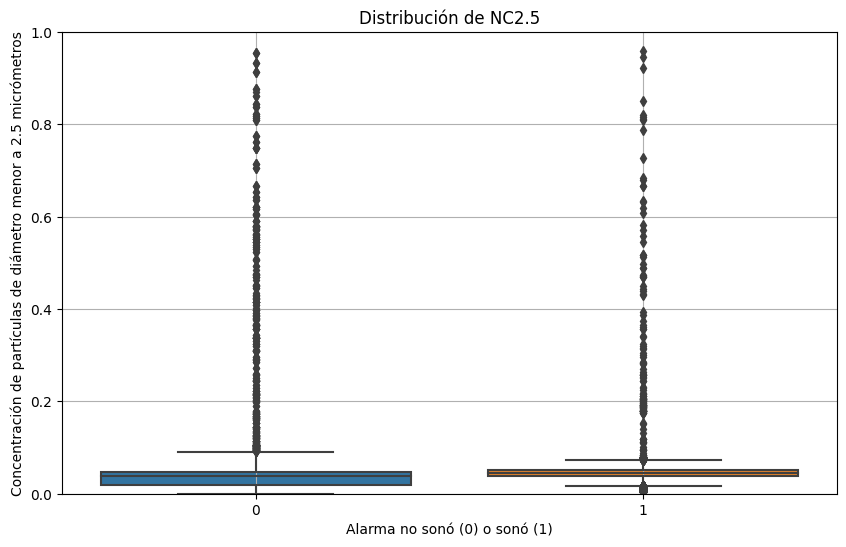

In [81]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.boxplot(x='Fire Alarm', y='NC2.5', data=df_smoke, ax=ax1)
plt.ylim(0, 50000)
plt.ylim(0, 1, 0.1)
ax1.set_xlabel('Alarma no sonó (0) o sonó (1)')
ax1.set_ylabel('Concentración de partículas de diámetro menor a 2.5 micrómetros')
ax1.set_title('Distribución de NC2.5')
ax1.grid(True)


plt.show()

In [82]:
x_h = df_smoke['NC2.5'].dropna()
y_h = df_smoke['Fire Alarm'].dropna()

corr = x_h.corr(y_h)

print('Coeficiente de correlación NC2.5:', corr)

Coeficiente de correlación NC2.5: -0.05770743181206101


## Mapa de correlación de [Pearson](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b) 
para ver si existe alguna relación entre las otras variables.

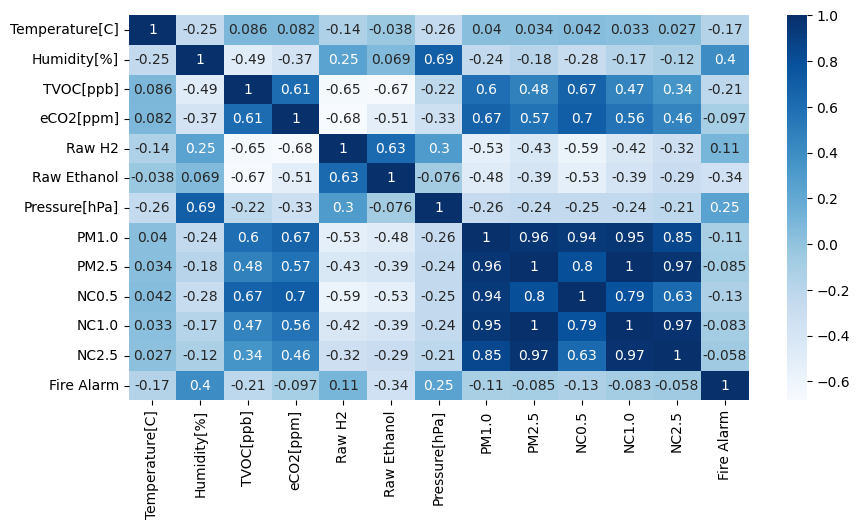

Fire Alarm    1.0
Name: Fire Alarm, dtype: float64

In [83]:
plt.figure(figsize=(10,5))
cor = df_smoke.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

#Correlation with output variable
cor_target = abs(cor['Fire Alarm'])#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Confirmamos que la activación de la alarma no tiene alta correlación con ninguna de las variables. Vemos que mientras mas oscuro es el color en el mapa, mayor es la correlación entre variables. Obviamente las concentraciones de particulas PM y NC estan todas altamente correlacionadas entre sí.
Humedad y presión están medianamente correlacionadas, al igual que etanol y H<sub>2</sub> crudos. También se relacionan CO<sub>2</sub> con TVOC, PM y NC.

# Feature selection

In [84]:
from scipy import stats

In [85]:
X = df_smoke.drop("Fire Alarm", axis=1) 
y = df_smoke['Fire Alarm']               # target feature
df_smoke.head()
X

from scipy import stats
q1 = X.quantile(0.25)
q3 = X.quantile(0.75)
iqr = q3 - q1 
X_r= X.copy()

X_r=X_r.drop('UTC',axis='columns')
X_r

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
CNT,,,,,,,,,,,,
0,20,57,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000
1,20,56,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000
2,20,55,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000
3,20,55,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000
4,20,54,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
5739,18,15,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015
5740,18,15,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015
5741,18,15,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014


In [86]:
X_r['outlier_iqr'] = X_r.apply(lambda row: 1 if any(np.abs(row - q3) > 1.5*iqr) else 0, axis=1)
X_r['outlier_iqr'].value_counts()

1    40025
0    22605
Name: outlier_iqr, dtype: int64

In [87]:
med = X.median()
X_r['outlier_tukey']=X_r.drop(columns='outlier_iqr').apply(lambda row: 1 if any(np.abs(row - med) > 1.5*iqr) else 0, axis=1)
X_r['outlier_tukey'].value_counts()

1    38479
0    24151
Name: outlier_tukey, dtype: int64

In [88]:
X_r[~((X_r['outlier_iqr']==1) & (X_r['outlier_tukey']==1))]

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,outlier_iqr,outlier_tukey
CNT,,,,,,,,,,,,,,
1402,26,55,30,400,13093,19974,939.679,0.75,0.77,5.13,0.800,0.018,1,0
1403,26,55,20,400,13101,19987,939.672,0.79,0.82,5.44,0.849,0.019,1,0
1404,26,55,31,400,13092,19977,939.676,0.85,0.89,5.86,0.914,0.021,1,0
1405,26,55,22,400,13097,19984,939.680,0.87,0.90,5.97,0.931,0.021,1,0
1406,26,55,27,400,13092,19986,939.665,0.89,0.92,6.10,0.952,0.021,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24989,26,47,1325,413,12985,19397,938.861,1.61,1.67,11.06,1.724,0.039,0,0
24990,26,47,1343,422,12989,19403,938.860,1.60,1.66,11.03,1.719,0.039,0,0
24991,25,47,1385,445,12972,19374,938.872,1.58,1.64,10.86,1.694,0.038,0,0


In [89]:
indexes=X_r[~((X_r['outlier_iqr']==1) & (X_r['outlier_tukey']==1))].index
X_n= X.iloc[indexes]
y_n= y.iloc[indexes]

X_n=X_n.drop('UTC',axis='columns')
X_n.shape

(25957, 12)

### Forward selection

In [90]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [91]:
import statsmodels.api as sm
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist() # lista con columnas
    best_features = [] # lista vacia para guardar features significativos
    while (len(initial_features)>0): # siempre y cuando esto sea mayor que 0 seguir
        remaining_features = list(set(initial_features)-set(best_features)) # operacion diferencia todas - features que van saliendo
        new_pval = pd.Series(index=remaining_features) # seria para guardar p valores
        for new_column in remaining_features: # para las columnas restates seguir evaluando
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit() # ajustar el modelo con target agregando columnas de una en una
            new_pval[new_column] = model.pvalues[new_column] # agregar a la serie el p valor para cada feature
        min_p_value = new_pval.min() # encontrar el p valor minimo (mas significativo)
        if(min_p_value<significance_level): # verificar si es menor a alpha
            best_features.append(new_pval.idxmin()) # agregar el nombre del feature
        else:
            break # cuando no se cumpla la condicion parar y salir
    return best_features

In [92]:
X_n.columns

Index(['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2',
       'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0',
       'NC2.5'],
      dtype='object')

In [93]:
import warnings
warnings.filterwarnings("ignore")
forward_selection(X_n,y_n)

['PM1.0',
 'TVOC[ppb]',
 'Humidity[%]',
 'Temperature[C]',
 'Raw H2',
 'Raw Ethanol',
 'eCO2[ppm]',
 'Pressure[hPa]',
 'PM2.5']

De las 12 columnas, al parecer solo 10 son significativas. PM2.5 Y NC1.0 no son relevantes

### Backward selection

In [94]:
def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist() # arrancamos con todas las columnas
    while(len(features)>0): # siempre y cuando haya mas de 1 feature seguir
        features_with_constant = sm.add_constant(data[features]) # hacer el modelo con todas las variables e ir removiendo
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:] # ajustar el modelo y sacar p valores
        max_p_value = p_values.max() # sacar el p valor maximo
        if(max_p_value >= significance_level): # verificar si es mayor a la significancia
            excluded_feature = p_values.idxmax() # de ser asi remover el feature por ser no significativo
            features.remove(excluded_feature) # remover de la lista de fetures
        else:
            break # cuando no se cumpla el if se parara el ciclo
    return features

In [95]:
backward_elimination(X_n,y_n)

['Temperature[C]',
 'Humidity[%]',
 'TVOC[ppb]',
 'eCO2[ppm]',
 'Raw H2',
 'Raw Ethanol',
 'Pressure[hPa]',
 'PM1.0',
 'PM2.5']

De las 12 columnas, al parecer solo 9 son significativas. NC0.5, NC1.0 Y NC2.5 no son relevantes

### Stepwise selection

In [96]:
def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

In [97]:
stepwise_selection(X_n,y_n)

['PM1.0',
 'Humidity[%]',
 'Temperature[C]',
 'Raw H2',
 'eCO2[ppm]',
 'Raw Ethanol',
 'TVOC[ppb]',
 'Pressure[hPa]',
 'PM2.5']

In [ ]:
stepwise_selection(X_n,y_n)

['PM1.0',
 'Humidity[%]',
 'Temperature[C]',
 'Raw H2',
 'eCO2[ppm]',
 'Raw Ethanol',
 'TVOC[ppb]',
 'Pressure[hPa]',
 'PM2.5']

De las 12 columnas, al parecer solo 9 son significativas. NC0.5, NC1.0 Y NC2.5 no son relevantes

#### Los dos últimos métodos dieron iguales entre sí pero diferentes al método forward, así que nos vamos a quedar con uno de los últimos.

# Algoritmo de clasificación

La pregunta que se quiere responder es si se activará o no la alarma en función de los parámetros registrados. Para ello, conviene utilizar aprendizaje supervisado de clasificación. 

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_n, y_n, test_size=0.2, random_state=42)

### Árboles de decisión

In [99]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
clf = DecisionTreeClassifier(random_state=1234,criterion='gini',max_depth=5)
model = clf.fit(X_train, y_train)

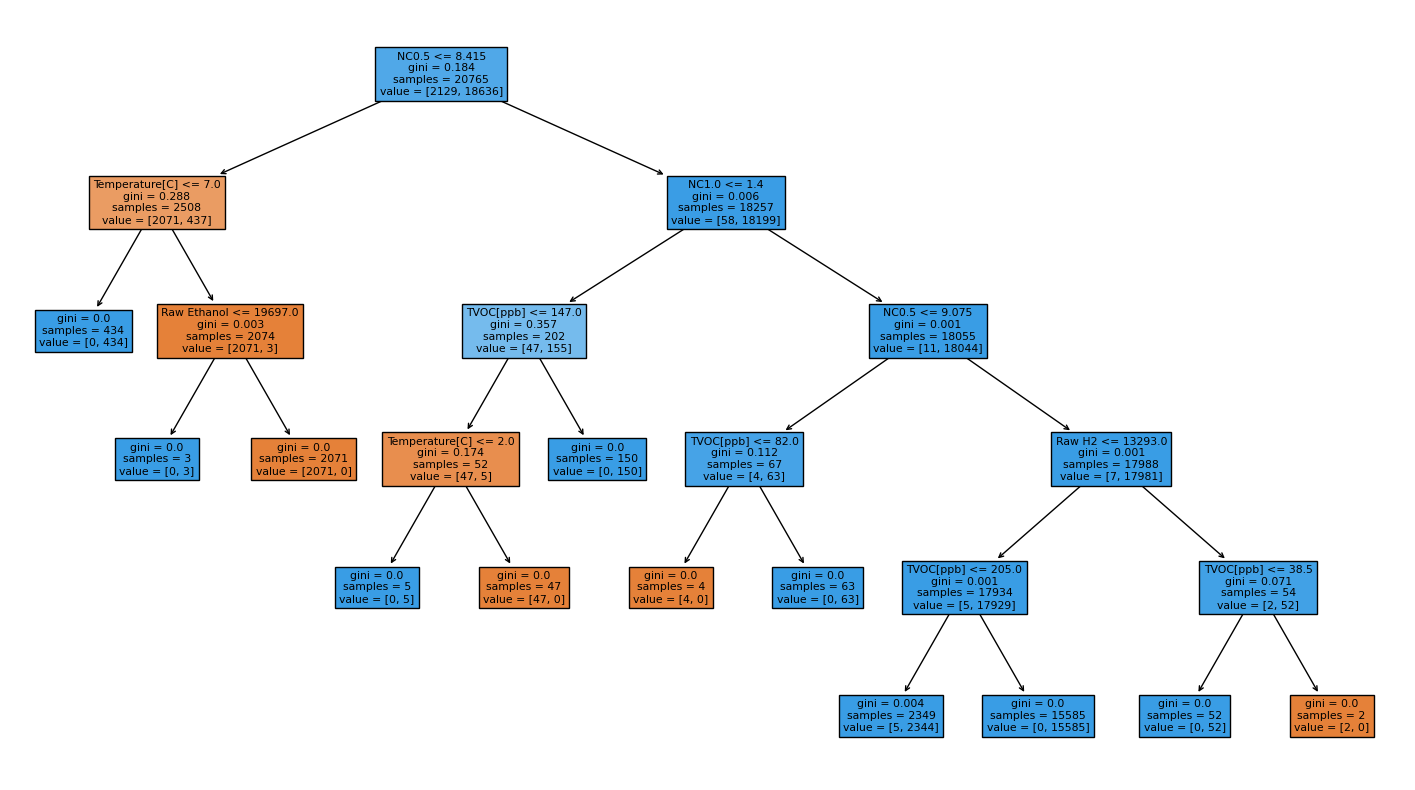

In [100]:
fig = plt.figure(figsize=(18,10))
_ = tree.plot_tree(clf,feature_names=X_train.columns,filled=True)
plt.savefig("decision_tree_new.png", bbox_inches='tight')

In [101]:
from sklearn.metrics import classification_report
y_pred=clf.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       511
           1       1.00      1.00      1.00      4681

    accuracy                           1.00      5192
   macro avg       1.00      1.00      1.00      5192
weighted avg       1.00      1.00      1.00      5192



Podemos ver que la precisión retornada es de 1 tanto para cuando suena la alarma como para cuando no suena. Es decir, el modelo es capaz de predecir con precisión del 100% si la alarma va a sonar o no. Podemos ver también que el f1-score es de 1 para la activacion de la alarma, es decir que no solo tiene buena precisión, sino tambien buena sensibilidad. Para la no activación de alarma tiene un f1-score de 0.99, lo cual es igualmente destacable. 

In [102]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [103]:
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)
# Obtenemos las predicciones del modelo con X_test
preds = modelo.predict(X_test) 
preds

array([1, 1, 1, ..., 1, 1, 1])

In [104]:
confusion = metrics.confusion_matrix(y_test, preds)
confusion.ravel()

array([ 509,    2,    0, 4681])

Vemos que no hay falsos positivos ni falsos negativos, todo se predijo correctamente

# Conclusión

No se determinó una correlación significativa entre la variable target (alarma) y el resto de las variables. Esto hizo que todas las hipótesis generadas sean descartadas.

Se fue capaz de entrenar un modelo usando el 80% de la base de datos como entrada de entrenamiento, el otro 20% fue utilizado para testear el modelo. Se utilizo aprendizaje supervisado de clasificación, específicamente de decision tree. El modelo obtenido tuvo una precisión y sensibilidad del 100% para la activación de la alarma. Esto indica que se puede incorporar en los sensores para mejorar su rendimiento.